In [ ]:
from IPython.display import clear_output
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from typing import List
from tqdm.notebook import tqdm

!pip install transformers SentencePiece pytorch-lightning x-transformers librosa

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pytorch_lightning as pl
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score
import torchmetrics
import pickle
import os

from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from scipy.stats import spearmanr
import librosa

clear_output()

In [ ]:
from text_classification_model import NN_Classifier, Text_Classification
from audio_classification_model import AudioModel

In [ ]:
text_model = model1.load_from_checkpoint('./trained/text_model.ckpt')

In [ ]:
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm

def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.mean(axis=1)

df = csv

X = []
y = []

for _, row in tqdm(df.iterrows()):
    try:
        file_path = f"./file/{row['wav_id']}.wav"
        mfcc_features = extract_mfcc(file_path)
        X.append(mfcc_features)
        y.append(row['상황'])
    except:
        pass

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

19374it [08:11, 39.43it/s]


              precision    recall  f1-score   support

          기쁨       0.33      0.64      0.44       949
          당황       0.31      0.06      0.10       361
          분노       0.29      0.28      0.28       655
          불안       0.51      0.07      0.12       281
          상처       0.35      0.14      0.20       465
          슬픔       0.31      0.30      0.30       530
          중립       0.34      0.32      0.33       634

    accuracy                           0.33      3875
   macro avg       0.35      0.26      0.25      3875
weighted avg       0.34      0.33      0.29      3875



In [ ]:
from torch.utils.data import Dataset, DataLoader

class MultimodalDataset(Dataset):
    def __init__(self, X_audio, X_text, y):
        self.X_audio = X_audio
        self.X_text = X_text
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        audio_sample = self.X_audio[idx]
        text_sample = self.X_text[idx]
        label = self.y[idx]

        return {
            'audio': torch.tensor(audio_sample, dtype=torch.float32),
            'text': text_sample,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
from sklearn.model_selection import train_test_split

X_audio_train, X_audio_temp, X_text_train, X_text_temp, y_train, y_temp = train_test_split(
    X, input_ids, y, test_size=0.2, random_state=77
)

X_audio_val, X_audio_test, X_text_val, X_text_test, y_val, y_test = train_test_split(
    X_audio_temp, X_text_temp, y_temp, test_size=0.5, random_state=77
)

In [ ]:
train_dataset = MultimodalDataset(X_audio=X_audio_train, X_text=X_text_train, y=y_train)
val_dataset = MultimodalDataset(X_audio=X_audio_val, X_text=X_text_val, y=y_val)
test_dataset = MultimodalDataset(X_audio=X_audio_test, X_text=X_text_test, y=y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MultimodalModel(nn.Module):
    def __init__(self, audio_dim, text_dim, num_classes=7):
        super(MultimodalModel, self).__init__()

        self.audio_layer = nn.Linear(audio_dim, 128)

        self.encoder = TransformerWrapper(
            num_tokens = 4096,
            max_seq_len = 64,
            attn_layers = Encoder(
                dim = 512,
                depth = 1,
                heads = 2,
                macaron = True,
                attn_gate_values = True,
                attn_num_mem_kv = 16
            )
        )

        self.classifier = NN_Classifier()

    def forward(self, audio, text):
        audio_out = F.relu(self.audio_layer(audio))
        text_enc = self.text_encoder(text)
        text_out = F.relu(self.text_layer(text_enc[:, 0]))

        concatenated = torch.cat((audio_out, text_out), dim=1)
        logits = self.classifier(concatenated)

        return logits

In [ ]:
import pytorch_lightning as pl
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from sklearn.metrics import classification_report
import numpy as np

class MultimodalLightningModule(pl.LightningModule):
    def __init__(self, audio_dim, text_dim, lr=1e-4):
        super(MultimodalLightningModule, self).__init__()

        self.model = MultimodalModel(audio_dim, text_dim)
        self.lr = lr
        self._test_results = []

    def forward(self, audio, text):
        return self.model(audio, text)

    def training_step(self, batch, batch_idx):
        audio, text, labels = batch['audio'], batch['text'], batch['label']
        logits = self(audio, text)
        loss = cross_entropy(logits, labels)
        self.log('train_loss', loss, prog_bar = True)
        return loss

    def test_step(self, batch, batch_idx):
        audio, text, labels = batch['audio'], batch['text'], batch['label']
        logits = self(audio, text)
        _, predicted = torch.max(logits, 1)
        self._test_results.append({'predicted': predicted.detach().cpu(), 'true': labels.detach().cpu()})

    def on_test_epoch_end(self):
        all_predicted = torch.cat([x['predicted'] for x in self._test_results])
        all_true = torch.cat([x['true'] for x in self._test_results])

        print(classification_report(all_true.numpy(), all_predicted.numpy()))

    def validation_step(self, batch, batch_idx):
        audio, text, labels = batch['audio'], batch['text'], batch['label']
        logits = self(audio, text)
        val_loss = cross_entropy(logits, labels)
        self.log('val_loss', val_loss, prog_bar = True)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    verbose=True
)

checkpoint = ModelCheckpoint(
    monitor="val_loss", mode="min", save_weights_only=True
)


model = MultimodalLightningModule(audio_dim=X_audio_train.shape[1], text_dim=8002)
trainer = Trainer(max_epochs=10,
                  accelerator="gpu",
                  devices="auto",
                  log_every_n_steps=100,
                  precision=16,
                  gradient_clip_val=0,
                  accumulate_grad_batches=1,
                  val_check_interval=1.0,
                  callbacks=[checkpoint, LearningRateMonitor("step"), early_stopping],
                  )

trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type            | Params
------------------------------------------
0 | model | MultimodalModel | 13.6 M
------------------------------------------
13.6 M    Trainable params
0         Non-trainable params
13.6 M    Total params
54.455    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.633


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 0.525


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 0.430


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.402


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.402. Signaling Trainer to stop.


In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get -qq install fonts-nanum
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

Selecting previously unselected package fonts-nanum.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
checkpoint_path = trainer.checkpoint_callback.best_model_path
checkpoint_path

'/content/lightning_logs/version_19/checkpoints/epoch=4-step=2425.ckpt'

In [ ]:
trainer.test(model, ckpt_path=checkpoint.best_model_path, dataloaders=[test_loader])

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_19/checkpoints/epoch=4-step=2425.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_19/checkpoints/epoch=4-step=2425.ckpt


Testing: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       0.88      0.95      0.92       435
           1       0.96      0.87      0.91       177
           2       0.87      0.77      0.82       311
           3       0.93      0.94      0.94       169
           4       0.86      0.83      0.85       238
           5       0.88      0.88      0.88       292
           6       0.84      0.90      0.87       316

    accuracy                           0.88      1938
   macro avg       0.89      0.88      0.88      1938
weighted avg       0.88      0.88      0.88      1938



[{}]

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_4/checkpoints/epoch=5-step=3966.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_4/checkpoints/epoch=5-step=3966.ckpt


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8702477812767029     │
│     test_acc_class_0      │     0.903097927570343     │
│     test_acc_class_1      │     0.652064859867096     │
│     test_acc_class_2      │    0.8699373006820679     │
│     test_acc_class_3      │    0.8703597187995911     │
│     test_acc_class_4      │    0.8072492480278015     │
│     test_acc_class_5      │     0.877202033996582     │
│     test_acc_class_6      │    0.8727821707725525     │
│          test_f1          │    0.8703398405995184     │
│         test_loss         │    0.41526639461517334    │
│      test_precision       │    0.8854232725765597     │
│        test_recall        │    0.8702477775676187     │
└───────────────────────────┴───────────────────────────┘

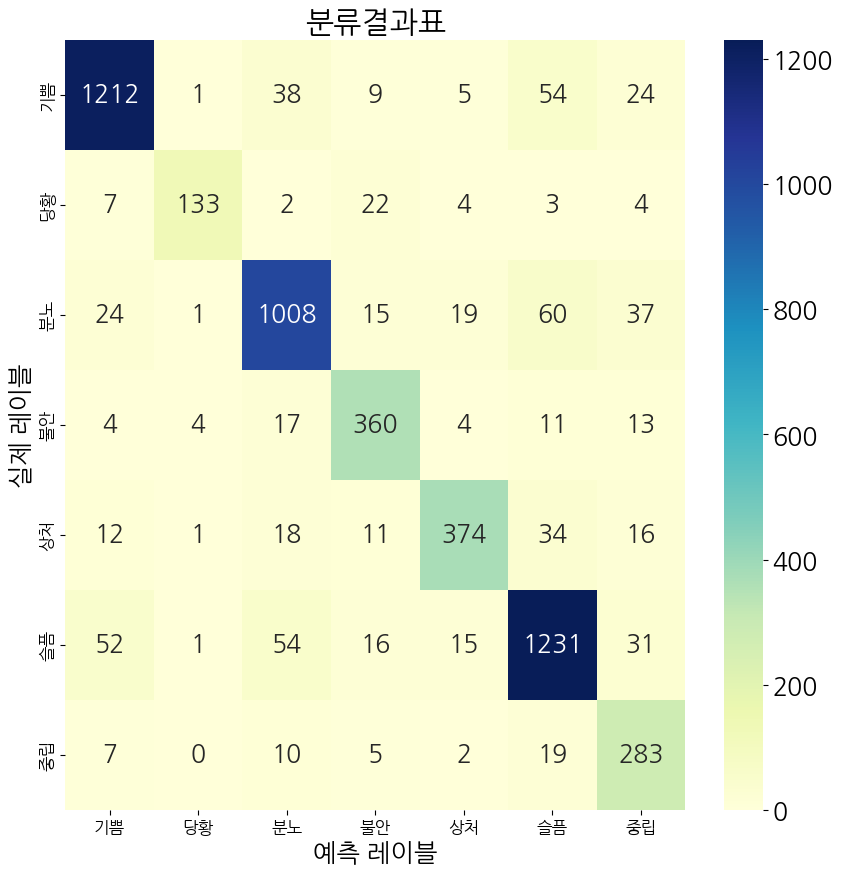

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('분류결과표')
    plt.xlabel('예측 레이블')
    plt.ylabel('실제 레이블')
    plt.xticks(ticks=np.arange(len(labels))+0.5, labels=labels, fontsize = 12)
    plt.yticks(ticks=np.arange(len(labels))+0.5, labels=labels, fontsize = 12)
    plt.show()

labels = le.inverse_transform(np.arange(len(le.classes_)))

model = Text_Classification(config)
trainer.test(model, ckpt_path=checkpoint.best_model_path, dataloaders=[test_loader])
plot_confusion_matrix(model.confusion_matrix, labels)